# Poker Parser

### Import functions

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz

def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

### Load and process data

In [2]:
dfraw = pd.read_csv('data_21_01_21.csv').reset_index(drop=True)
df = dfraw[dfraw['entry'].str.contains('Player stacks')].reset_index(drop=False)
df = df.rename(columns={'index':'original_index'})

In [3]:
for irow in range(len(df)):
    s = df.loc[irow,'entry']
    name_starts = find(s,'"')[::2]+1
    name_ends   = find(s,'@')-1
    num_starts  = find(s,'(')+1
    num_ends    = find(s,')')
    for iname in range(len(name_starts)):
        name = s[name_starts[iname]:name_ends[iname]]
        num  = s[num_starts[iname]:num_ends[iname]]
        df.loc[irow,name] = float(num)

names = [n for n in df.columns if n not in ['entry','at','order','original_index']]
for n in names:
    df[n+'_buybacks'] = 0
    df[n+'_buyback_total'] = 0
    
df = df[::-1].reset_index(drop=True)

### Account for buy-backs

In [4]:
buyback_rows = dfraw[dfraw['entry'].str.contains('joined')].reset_index(drop=False)
buyback_rows = buyback_rows.rename(columns={'index':'original_index'})[:-len(names)]

for i in list(range(len(buyback_rows)))[::-1]:
    etr = buyback_rows.loc[i,'entry']
    name = etr[etr.index('"')+1:etr.index('@')-1]
    num = etr[etr.index('of')+3:-1]
    at = buyback_rows.loc[i,'at'].replace('T',' ')
    time = at[at.index(':')-2:at.index(':')+3]
    yn = 0
    while yn not in ['y','n']:
        yn = input(f'Did {name} buy back in for {num} at {time}? [y/n] ')
    buyback_rows.loc[i,'is_buyback'] = (yn=='y')
    buyback_rows.loc[i,'amount'] = float(num)
    buyback_rows.loc[i,'name'] = name

Did Michael buy back in for 4.00 at 21:04? [y/n]  y


In [5]:
# Necessary. If you go all in, then buy back for less than you went all-in for, 
# I don't think there's a way of distinguishing it from losing the difference
# and then sitting out a round.

for i in range(len(buyback_rows)):
    if not buyback_rows.loc[i,'is_buyback']:
        continue
    # < since we have inverted df 
    ind = buyback_rows.loc[i,'original_index']
    amount = buyback_rows.loc[i,'amount']
    name = buyback_rows.loc[i,'name']

    df.loc[df['original_index']<ind, name] -= amount
    df.loc[df['original_index']<ind, name+'_buybacks'] += 1
    df.loc[df['original_index']<ind, name+'_buyback_total'] += amount

In [9]:
for nam in names:
    nanrows = df[pd.isnull(df[nam])]
    nanrows = nanrows.loc[[ind for ind in nanrows.index if ind-1 not in nanrows.index]]
    for i_n in range(len(nanrows)):
        index_of_row = nanrows.iloc[[i_n]].index[0]
        inbb = nanrows.loc[index_of_row, name+'_buybacks']
        for i_df in range(index_of_row, len(df)):
            if not np.isnan(df.loc[i_df, name]):
                if df.loc[i_df, name+'_buybacks'] == inbb+1:
                    inds_to_fill = list(range(index_of_row,i_df+1))
                    df.loc[inds_to_fill, name] = -nanrows.loc[index_of_row, name+'_buyback_total']
                break
        else:
            inds_to_fill = list(range(index_of_row,len(df)))
            df.loc[inds_to_fill, name] = -nanrows.loc[index_of_row, name+'_buyback_total']

In [10]:
df = df.bfill()

# Not inds that have no change = some error in accounting
inds_to_keep = [0] 
for i in range(1, len(df)):
    for nam in names:
        if df.loc[i, nam]!=df.loc[i-1, nam]:
            inds_to_keep.append(i)
            break
df = df.loc[inds_to_keep, names+['at']].reset_index(drop=True)

### Colour tester

['darkmagenta', 'forestgreen', 'coral', 'darkturquoise'] 



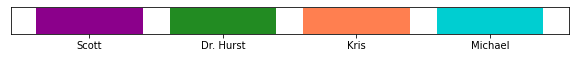

In [11]:
from matplotlib import colors as mcolors
cols = list(mcolors.CSS4_COLORS.keys())
cols = [c for c in cols if 'white' not in c]
np.random.shuffle(cols)

# Suggested colour scheme. Comment this line out to try random schemes.
cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise','grey']

plt.figure(figsize=[10,0.5])
for i,n in enumerate(names):
    plt.bar([names[i]], [1], color=cols[i])
    plt.xticks(rotation=0);
    plt.yticks([]);
print(cols[:len(names)], '\n')

# Some good colour schemes
# cols = ['mediumturquoise', 'grey', 'red', 'darkmagenta']
# cols = ['forestgreen', 'orange', 'purple', 'cornflowerblue']
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise']

### Plot total bankroll over time

In [16]:
df[names]

,Scott,Dr. Hurst,Kris,Michael
0,4.00,4.00,4.00,4.00
1,4.00,3.96,5.00,3.04
2,4.00,3.96,4.96,3.08
3,3.92,3.92,4.76,3.40
4,3.88,3.88,4.84,3.40
...,...,...,...,...
63,4.08,5.10,9.42,-2.60
64,4.08,5.18,9.38,-2.64
65,4.00,5.18,9.36,-2.54
66,5.62,5.02,9.36,-8.00


In [17]:
df.loc[66, 'Michael'] = -4
df.loc[67, 'Michael'] = -4

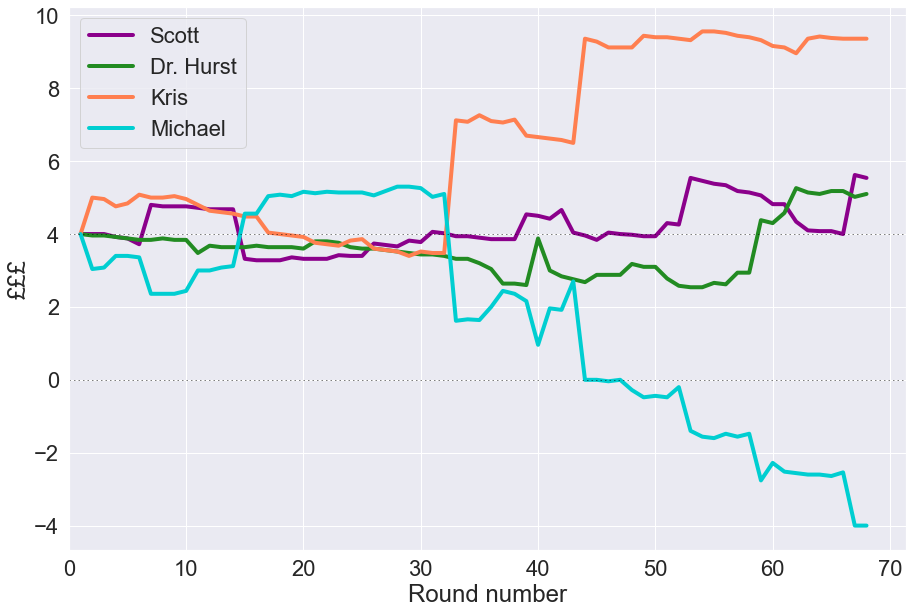

In [18]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)
for i,n in enumerate(names):
    plt.plot(np.arange(1,len(df)+1),df[n].values,label=n,color=cols[i],linewidth=4)
plt.legend()
plt.xlabel('Round number')
plt.ylabel('£££')
plt.xlim(left=0);
plt.gca().axhline(0,dashes=[3,6],linewidth=.5,color='black')
plt.gca().axhline(df.loc[0,names[0]],dashes=[3,6],linewidth=.5,color='black')

plt.savefig(f'poker_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Plot winnings and losses per round

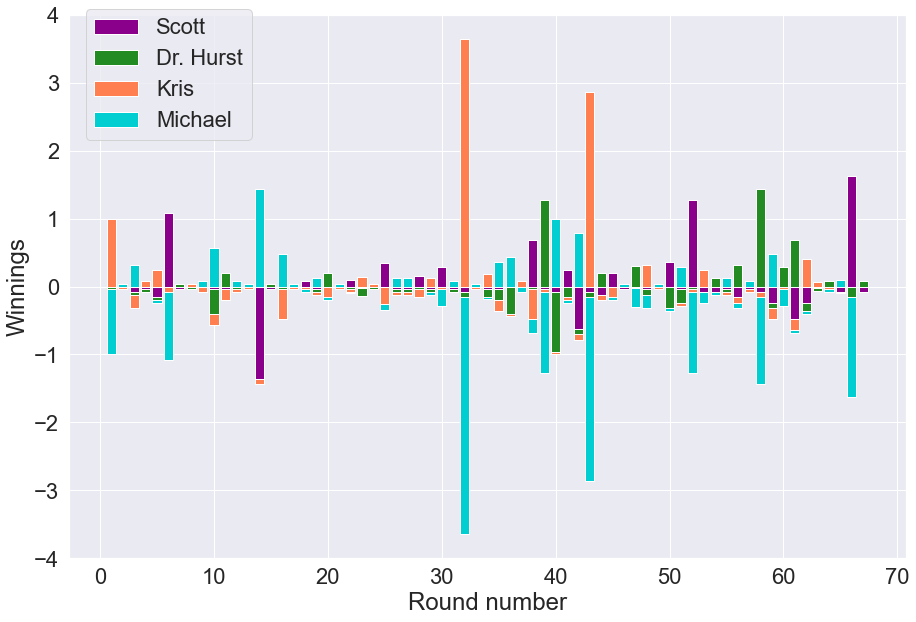

In [22]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)

previous = (np.arange(1,len(df))*0).astype(float)
for i,n in enumerate(names):
    diffs = np.diff(df[n])

    above_part = np.where(diffs>0, diffs, 0)
    plt.bar(np.arange(1,len(df)),above_part,color=cols[i], label=n, alpha=1)

    bottom_part = np.diff(df[n])
    bottom_part = np.where(diffs<0, -diffs, 0)
    previous-=bottom_part

    inds = np.where(bottom_part!=0)[0]
    y_plot = bottom_part[inds]
    x_plot = np.arange(1,len(df))[inds] 
    plt.bar(x_plot,y_plot,bottom=previous[inds],color=cols[i], alpha=1)


plt.legend(loc=[0.02,.77])
plt.xlabel('Round number')
plt.ylabel('Winnings')
range_ = 4

plt.ylim((-range_,range_));

plt.savefig(f'winnings_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Who won at which parts?

In [23]:
entries = dfraw['entry'][::-1]

all_hands = []
hand = []
active = 0
for i,e in enumerate(entries):
    if active and '--' not in e:
        hand.append(e)
    if '-- starting hand' in e:
        starter = i
        active = 1
    if '-- ending hand' in e:
        active = 0
        all_hands.append(hand)
        hand = []

In [27]:
def get_winner(hand,names):
    for row in hand:
        if 'collected' in row:
            for n in names:
                if n in row:
                    return n

def get_section(hand):
    for sec in ['River','Turn','Flop']:
        if sec in ' '.join(hand):
            return sec
    return 'Preflop'

In [43]:
win_on = pd.DataFrame({
    'Name':names,
    'Preflop':[0]*len(names),
    'Flop':[0]*len(names),
    'Turn':[0]*len(names),
    'River':[0]*len(names),
})

win_on = win_on.set_index('Name')

for h in all_hands:
    winner  = get_winner(h,names)
    section = get_section(h)
    win_on.loc[winner,section] += 1

win_on = win_on.reset_index(drop=False)

In [44]:
win_on

,Name,Preflop,Flop,Turn,River
0,Scott,0,0,1,12
1,Dr. Hurst,0,2,4,9
2,Kris,2,2,2,9
3,Michael,0,15,2,9


In [64]:
def bar_plotter(df, save=True):
    plt.figure(figsize=(10,5))
    sns.set(font_scale=2)
    
    rounds = [c for c in df.columns if c!='Name']
    names = list(df['Name'].values)
    
    main_ticks = np.arange(len(rounds))
    jump = 1/(len(names)+1)
    
    for i, n in enumerate(names):
        xpos = main_ticks + jump*i
        
        data_to_plot = [df.loc[df['Name']==n, r].values[0] for r in rounds]
        
        plt.bar(
            xpos,
            data_to_plot,
            width=jump*0.9,
            label=n.title(),
            color=cols[i]
        )
        
    plt.ylabel('Rounds won')
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    plt.gca().set_xticklabels(rounds)
    legend = plt.legend(title='Player', loc=[0.98,0.6])
    plt.setp(legend.get_title(),fontsize=15)
    plt.grid(axis='x')
    if save:
        plt.savefig(f'rounds_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')
    plt.show()

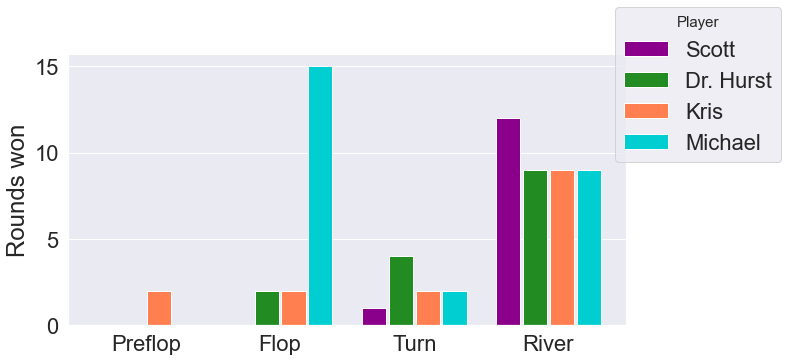

In [65]:
bar_plotter(win_on)